# Gradient Analysis of Forward Model

This notebook demonstrates gradient analysis of the forward model with respect to cosmological parameters.

We compute gradients of the MSE loss (relative to fiducial observations) with respect to Omega_c and sigma8 at multiple offsets from the fiducial values. This reveals the sensitivity of the forward model to cosmological parameters.

## Imports

In [1]:
import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"
os.environ["EQX_ON_ERROR"] = "nan"
os.environ["JAX_ENABLE_X64"] = "False"

import jax

jax.config.update("jax_enable_x64", False)

from pathlib import Path

import jax.numpy as jnp
import jax_cosmo as jc
import matplotlib.pyplot as plt
import numpy as np
import numpyro.distributions as dist
from diffrax import RecursiveCheckpointAdjoint
from jaxpm.distributed import normal_field
from jaxpm.spherical import spherical_visibility_mask

from fwd_model_tools import Configurations, Planck18
from fwd_model_tools.lensing_model import (
    compute_box_size_from_redshift,
    make_full_field_model,
)
from fwd_model_tools.plotting import plot_gradient_analysis

print(f"JAX devices: {jax.device_count()}")
print(f"JAX backend: {jax.default_backend()}")

JAX devices: 1
JAX backend: gpu


## Configuration

In [2]:
output_dir = "output_01_gradient"
box_shape = (256 , 256 , 256)
max_redshift = 0.5
number_of_shells = 8
geometry = "spherical"
observer_position = (0.5, 0.5, 1.0)
magick_seed = 42

gradient_offset_omega_c = 0.05
gradient_offset_sigma8 = 0.1

output_dir_path = Path(output_dir)
plots_dir = output_dir_path / "plots"
plots_dir.mkdir(parents=True, exist_ok=True)

fiducial_cosmology = Planck18()
box_size = compute_box_size_from_redshift(fiducial_cosmology, max_redshift, observer_position)

print(f"Box size: {box_size} Mpc/h")
print(f"Max redshift: {max_redshift}")
print(f"Observer position: {observer_position}")

Box size: (2635.3309394476964, 2635.3309394476964, 1317.6654697238482) Mpc/h
Max redshift: 0.5
Observer position: (0.5, 0.5, 1.0)


## Create Redshift Distribution

In [3]:
from scipy.stats import norm

z = jnp.linspace(0, max_redshift, 1000)
z_centers = jnp.linspace(0.2, max_redshift - 0.01, 4)
z_centers = jnp.round(z_centers, 3)
print(f"z_centers = {z_centers}")

nz_shear = [
    jc.redshift.kde_nz(
        z,
        norm.pdf(z, loc=z_center, scale=0.12),
        bw=0.01,
        zmax=max_redshift,
        gals_per_arcmin2=g,
    )
    for z_center, g in zip(z_centers, [7, 8.5, 7.5, 7])
]
nbins = len(nz_shear)

z_centers = [0.2   0.297 0.393 0.49 ]


## Setup Configuration

In [4]:
config = Configurations(
    field_size=9.6,
    field_npix=box_shape[0],
    box_shape=box_shape,
    box_size=box_size,
    number_of_shells=number_of_shells,
    density_plane_npix=box_shape[0],
    nside=box_shape[0],
    density_plane_smoothing=0.1,
    nz_shear=nz_shear,
    fiducial_cosmology=Planck18,
    sigma_e=0.3,
    priors={
        "Omega_c": dist.Uniform(0.24, 0.28),
        "sigma8": dist.Uniform(0.78, 0.82),
    },
    t0=0.1,
    dt0=0.1,
    t1=1.0,
    min_redshift=0.01,
    max_redshift=max_redshift,
    sharding=None,
    halo_size=0,
    adjoint=RecursiveCheckpointAdjoint(4),
    geometry=geometry,
    observer_position=observer_position,
    log_lightcone=False,
    log_ic=False,
)

print("Configuration created")

Configuration created


## Generate Initial Conditions

In [5]:
initial_conditions = normal_field(
    jax.random.key(magick_seed), config.box_shape, sharding=config.sharding
)
print("Initial conditions generated")

Initial conditions generated


## Instantiate Forward Model

In [6]:
forward_model = make_full_field_model(
    field_size=config.field_size,
    field_npix=config.field_npix,
    box_shape=config.box_shape,
    box_size=config.box_size,
    number_of_shells=config.number_of_shells,
    density_plane_npix=config.density_plane_npix,
    density_plane_smoothing=config.density_plane_smoothing,
    nside=config.nside,
    adjoint=config.adjoint,
    t0=config.t0,
    dt0=config.dt0,
    t1=config.t1,
    min_redshift=config.min_redshift,
    max_redshift=config.max_redshift,
    sharding=config.sharding,
    halo_size=config.halo_size,
    geometry=config.geometry,
    observer_position=config.observer_position,
)
print("Forward model created")

Forward model created


## Generate Fiducial Observations

In [7]:
visible_mask = spherical_visibility_mask(config.nside, config.observer_position)
visible_indices = jnp.where(visible_mask == 1)[0]

kappas_fiducial, _, _ = forward_model(fiducial_cosmology, nz_shear, initial_conditions)
kappas_fiducial_visible = {f"kappa_{i}": k[visible_indices] for i, k in enumerate(kappas_fiducial)}

print(f"Generated {len(kappas_fiducial)} fiducial kappa maps")
print(f"Number of visible pixels: {len(visible_indices)}")

/lustre/fswork/projects/rech/tkc/commun/venv/nbody/lib/python3.11/site-packages/jax/_src/ops/scatter.py:108: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion=standard. In future JAX releases this will result in an error.
  warnings.warn(


Generated 4 fiducial kappa maps
Number of visible pixels: 393728


## Define Gradient Computation Functions

In [8]:
def compute_mse_loss(param_val, param_name, cosmo, nz_shear, ic, kappa_obs):
    cosmo_dict = {
        "Omega_c": cosmo.Omega_c,
        "Omega_b": cosmo.Omega_b,
        "h": cosmo.h,
        "n_s": cosmo.n_s,
        "sigma8": cosmo.sigma8,
        "Omega_k": cosmo.Omega_k,
        "w0": cosmo.w0,
        "wa": cosmo.wa,
    }
    cosmo_dict[param_name] = param_val
    test_cosmo = jc.Cosmology(**cosmo_dict)
    test_cosmo._workspace = {}

    kappas, _, _ = forward_model(test_cosmo, nz_shear, ic)
    kappas_visible = [k[visible_indices] for k in kappas]

    mse = sum(
        jnp.mean((k - kappa_obs[f"kappa_{i}"]) ** 2) for i, k in enumerate(kappas_visible)
    )
    return mse / len(kappas_visible)


def compute_loss_and_gradient(param_val, param_name, cosmo, nz_shear, ic, kappa_obs):
    loss_fn = lambda pval: compute_mse_loss(pval, param_name, cosmo, nz_shear, ic, kappa_obs)
    loss_value = float(loss_fn(param_val))
    grad_value = float(jax.grad(loss_fn)(param_val))
    return loss_value, grad_value


print("Gradient computation functions defined")

Gradient computation functions defined


## Compute Gradients for Omega_c

In [9]:
params_to_test = {
    "Omega_c": {
        "fiducial": fiducial_cosmology.Omega_c,
        "offset": gradient_offset_omega_c,
    },
    "sigma8": {
        "fiducial": fiducial_cosmology.sigma8,
        "offset": gradient_offset_sigma8,
    },
}

results = {}

print("Computing gradients for Omega_c")
print("-" * 60)

param_name = "Omega_c"
param_info = params_to_test[param_name]
fiducial_val = param_info["fiducial"]
offset = param_info["offset"]

offsets = jnp.array([-2 * offset, -offset, 0.0, offset, 2 * offset])
values = fiducial_val + offsets

losses = []
gradients = []
for i, (off, val) in enumerate(zip(offsets, values)):
    print(f"  [{i+1}/5] {param_name} = {val:.4f} (offset = {off:+.4f})")

    loss_val, grad_val = compute_loss_and_gradient(
        val, param_name, fiducial_cosmology, nz_shear, initial_conditions, kappas_fiducial_visible
    )
    losses.append(loss_val)
    gradients.append(grad_val)

    print(f"        MSE Loss = {loss_val:.6e}")
    print(f"        d(MSE)/d({param_name}) = {grad_val:.6e}")

results[param_name] = {
    "offsets": offsets,
    "losses": jnp.array(losses),
    "gradients": jnp.array(gradients),
}

Computing gradients for Omega_c
------------------------------------------------------------
  [1/5] Omega_c = 0.1607 (offset = -0.1000)
        MSE Loss = 7.010915e-05
        d(MSE)/d(Omega_c) = -2.488325e-04
  [2/5] Omega_c = 0.2107 (offset = -0.0500)
        MSE Loss = 5.254287e-05
        d(MSE)/d(Omega_c) = -4.772835e-04
  [3/5] Omega_c = 0.2607 (offset = +0.0000)
        MSE Loss = 6.064603e-28
        d(MSE)/d(Omega_c) = -9.253193e-17
  [4/5] Omega_c = 0.3107 (offset = +0.0500)
        MSE Loss = 5.918964e-05
        d(MSE)/d(Omega_c) = 7.372158e-04
  [5/5] Omega_c = 0.3607 (offset = +0.1000)
        MSE Loss = 9.108080e-05
        d(MSE)/d(Omega_c) = 5.399517e-04


## Compute Gradients for sigma8

In [10]:
print("\nComputing gradients for sigma8")
print("-" * 60)

param_name = "sigma8"
param_info = params_to_test[param_name]
fiducial_val = param_info["fiducial"]
offset = param_info["offset"]

offsets = jnp.array([-2 * offset, -offset, 0.0, offset, 2 * offset])
values = fiducial_val + offsets

losses = []
gradients = []
for i, (off, val) in enumerate(zip(offsets, values)):
    print(f"  [{i+1}/5] {param_name} = {val:.4f} (offset = {off:+.4f})")

    loss_val, grad_val = compute_loss_and_gradient(
        val, param_name, fiducial_cosmology, nz_shear, initial_conditions, kappas_fiducial_visible
    )
    losses.append(loss_val)
    gradients.append(grad_val)

    print(f"        MSE Loss = {loss_val:.6e}")
    print(f"        d(MSE)/d({param_name}) = {grad_val:.6e}")

results[param_name] = {
    "offsets": offsets,
    "losses": jnp.array(losses),
    "gradients": jnp.array(gradients),
}

print("\nGradient computation completed")


Computing gradients for sigma8
------------------------------------------------------------
  [1/5] sigma8 = 0.6102 (offset = -0.2000)
        MSE Loss = 6.411461e-05
        d(MSE)/d(sigma8) = -8.181901e-05
  [2/5] sigma8 = 0.7102 (offset = -0.1000)
        MSE Loss = 4.965172e-05
        d(MSE)/d(sigma8) = -2.259660e-04
  [3/5] sigma8 = 0.8102 (offset = +0.0000)
        MSE Loss = 3.565554e-28
        d(MSE)/d(sigma8) = 4.432898e-17
  [4/5] sigma8 = 0.9102 (offset = +0.1000)
        MSE Loss = 5.113809e-05
        d(MSE)/d(sigma8) = 2.639872e-04
  [5/5] sigma8 = 1.0102 (offset = +0.2000)
        MSE Loss = 7.250626e-05
        d(MSE)/d(sigma8) = 1.698150e-04

Gradient computation completed


## Plot Gradient Analysis

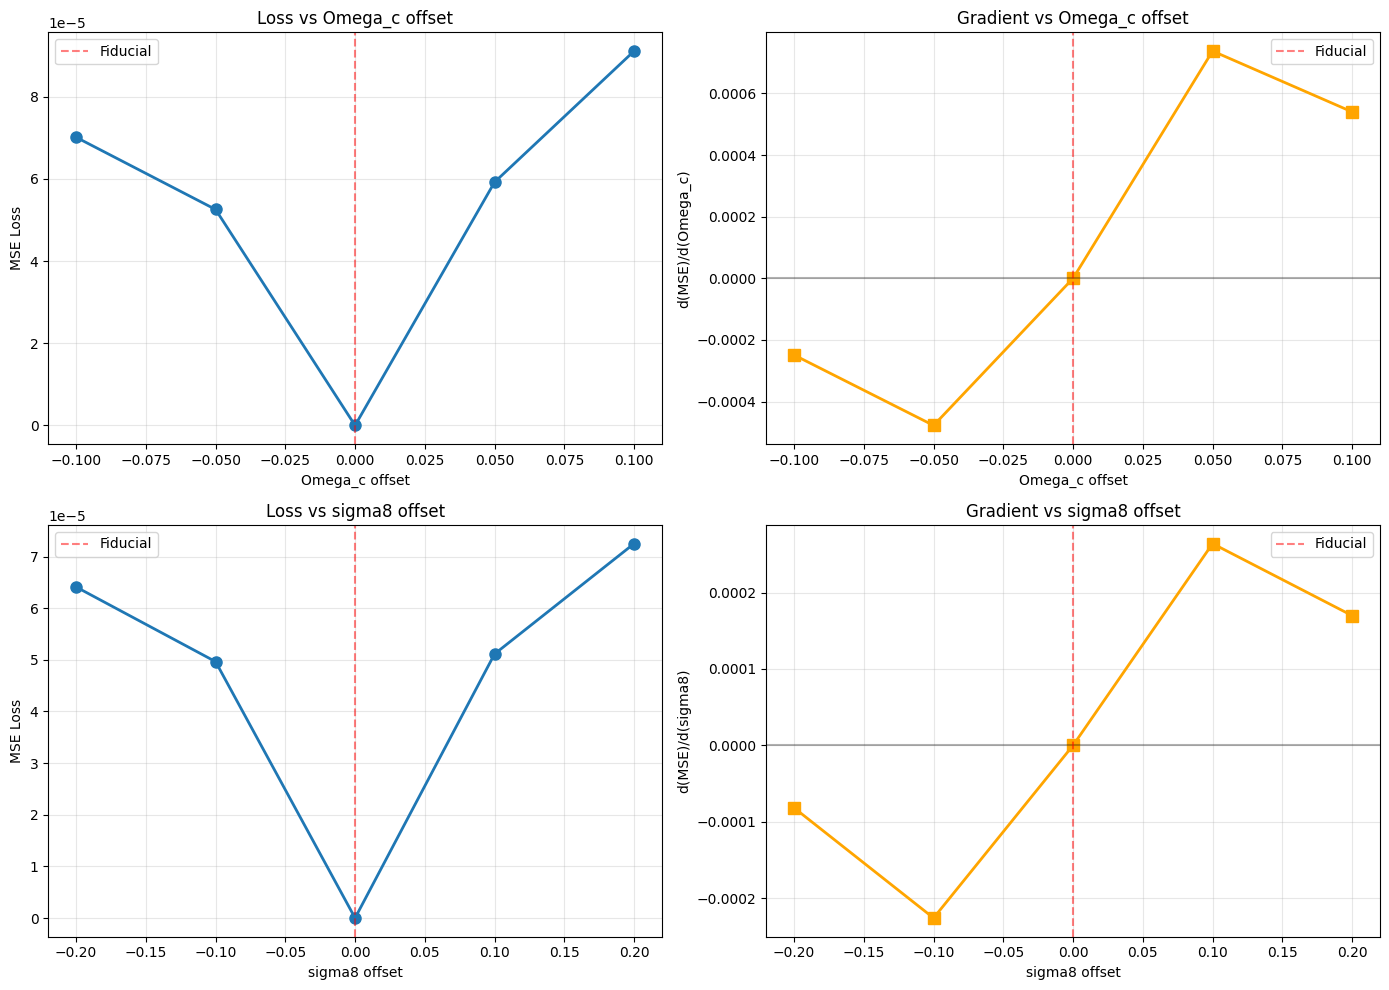

Gradient analysis plot saved to output_01_gradient/plots/gradient_analysis.png


In [11]:
plot_gradient_analysis(results, params_to_test, plots_dir, output_format="show")
print(f"Gradient analysis plot saved to {plots_dir / 'gradient_analysis.png'}")